In [1]:
import gurobipy as gpy

In [2]:
model = gpy.Model('mulearn-scaled')

Academic license - for non-commercial use only - expires 2022-05-19
Using license file /home/malchiodi/.gurobi/gurobi.lic


In [3]:
x1 = model.addVar(name=f'x1', vtype=gpy.GRB.CONTINUOUS, lb=0, ub=1)
x2 = model.addVar(name=f'x2', vtype=gpy.GRB.CONTINUOUS, lb=0, ub=1)

In [4]:
l0 = 200
l1 = -200

In [5]:
x1.start = .45
x2.start = .55

In [6]:
obj = x1**2 +x2**2 + l0 * (x1 + x2 - 1) + l1 * (1 - x1 - x2)

In [7]:
model.setObjective(obj, gpy.GRB.MAXIMIZE)
#model.setParam("NonConvex", 2)

In [8]:
model.update()
model.optimize()

Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (linux64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 0 rows, 2 columns and 0 nonzeros
Model fingerprint: 0x9d2b64a0
Model has 2 quadratic objective terms
Coefficient statistics:
  Matrix range     [0e+00, 0e+00]
  Objective range  [4e+02, 4e+02]
  QObjective range [2e+00, 2e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [0e+00, 0e+00]
Presolve removed 0 rows and 2 columns
Presolve time: 0.02s
Presolve: All rows and columns removed

Barrier solved model in 0 iterations and 0.02 seconds
Optimal objective 4.02000000e+02


In [9]:
x1.x

1.0

In [10]:
x2.x

1.0

In [11]:
model.objVal

402.0

In [1]:
import tensorflow as tf
import numpy as np

2022-03-22 14:25:49.149956: W tensorflow/stream_executor/platform/default/dso_loader.cc:59] Could not load dynamic library 'libcudart.so.10.1'; dlerror: libcudart.so.10.1: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/malchiodi/share/gurobi811/lib:
2022-03-22 14:25:49.149975: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


# Rifacciamo tutto

## Rilassamento lineare del vincolo di = e forma quadratica sviluppata

In [2]:
# E' QUELLO GIUSTO

from tensorflow.keras.optimizers import Adam

def solve_problem(Q, q, A, b, C, d,
                  max_iter=1000,
                  max_gap=1E-4,
                  alpha_0=1E-1,
                  window_width=30,
                  learning_rate=1E-2,
                  verbose=False):
    '''Solves the lagrangian relaxation for a constrained optimization
    problem and returns its result. The structure of the primal problem
    is the following
    
    min x.T Q x + q.T x
    subject to
    A x = b
    C x <= d
    
    where .T denotes the transposition operator. Optimization takes place
    in a iterated two-steps procedure: an outer process devoted to modifying
    the values of the lagrange multipliers, and an inner process working on
    the primal variables.
    
    The arguments are as follows, given n as the number of variables of
    the primal problem (i.e., the length of x)
    
    - Q: n x n matrix containing the quadratic coefficients of the cost
      function;
    - q: vector containing the n linear coefficients of the cost function
    - A: s x n matrix containing the coefficients of the = constraints
    - b: vector containing the s right members of the = constraints
    - C: t x n matrix containing the coefficients of the <= constraings
    - d: vector containing the t right members of the <= coefficients
    - max_iter: maximum number of iterations of the *outer* optimization
      procedure
    - max_gap: maximum gap between primal and dual objectives ensuring
      premature end of the *outer* optimization procedure
    - alpha_0: initial value of the learning rate in the *outer* optimization
      procedure
    - window_width: width of the moving window on the objective function for
      the *inner* optimization process
    - verbose: boolean flag triggering verbose output
    
    returns
    '''
    
    optimizer = Adam(learning_rate=10**-2)

    x = tf.Variable(np.random.random(len(q)),
                    name='x',
                    trainable=True,
                    dtype=tf.float32)
    Q = tf.constant(np.array(Q), dtype='float32')
    q = tf.constant(np.array(q), dtype='float32')
    
    A = np.array(A)
    s = len(A)
    C = np.array(C)
    b = np.array(b)
    d = np.array(d)
    
    M = np.vstack([A, -A, C])
    m = np.hstack([b, -b, d])
    lambda_ = tf.constant(np.random.random(len(m)), dtype='float32')
    
    M = tf.constant(M, dtype='float32')
    m = tf.constant(m, dtype='float32')

    
    def original_objective():
        def obj():
            return tf.tensordot(tf.linalg.matvec(Q, x), x, axes=1) + \
                   tf.tensordot(q, x, axes=1)
        return obj

    def lagrangian_objective(lambda_):
        def obj():
            return tf.tensordot(tf.linalg.matvec(Q, x), x, axes=1) + \
                   tf.tensordot(q, x, axes=1) + \
                   tf.tensordot(lambda_, m - tf.linalg.matvec(M, x), axes=1)
        return obj

    obj_val = []
    lagr_val = []
    gap_val = []
    gap = max_gap + 1

    num_bad_iterations = 0
    prev_orig = np.inf

    i = 0
    
    while i < max_iter and (gap<0 or gap > max_gap):
        lagr_obj = lagrangian_objective(lambda_)
        orig_obj = original_objective()
        prev_lagr = 10*3
        curr_lagr = 0
        vals = []
        t = 0
        window_width = 30
        window = list(np.logspace(1, window_width, window_width))
        # this is to ensure a high value for the standard deviation
        # of the elements to which the window has been initialized 
        
        while (np.std(window)/abs(np.mean(window)) > 0.001 or t < 100) \
              and t < 1000:
            optimizer.minimize(lagr_obj, var_list=x)
            prev_lagr = curr_lagr
            curr_lagr = lagr_obj().numpy()
            vals.append(curr_lagr)
            t += 1
            window = window[1:]
            window.append(curr_lagr)
        
        curr_orig = orig_obj().numpy()
        if curr_orig < prev_orig:
            num_bad_iterations += 1

        prev_orig = curr_orig

        
        obj_val.append(curr_orig)
        lagr_val.append(curr_lagr)
        
        subgradient = (m - tf.linalg.matvec(M, x)).numpy()
        gap = tf.tensordot(lambda_[:2*s], m[:2*s] - \
              tf.linalg.matvec(M[:2*s], x), axes=1).numpy()
        gap_val.append(gap)
        
        if verbose and i%10 == 0:
            print(f'i={i}, dual={lagr_obj().numpy():.3f}, '
                  f'prim={orig_obj().numpy():.3f}, gap={gap:.6f}')
        
        alpha = alpha_0 / num_bad_iterations
        lambda_ = tf.maximum(0, lambda_ + alpha * subgradient)

        i += 1

    return obj_val, lagr_val, x, lambda_, gap_val

    

In [3]:
Q = [[1, 0], [0, 1]]
q = [0, 0]
A = [[1, 1]]
b = [1]
C = [[-1, -1], [1, 0], [0, 1], [-1, 0], [0, -1]]
d = [-1, 1, 1, 0, 0]

obj_val, lagr_val, x, lambda_, gap = solve_problem(Q, q, A, b, C, d, max_gap=10**-4, verbose=True)

2022-03-22 14:26:16.553431: W tensorflow/stream_executor/platform/default/dso_loader.cc:59] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/malchiodi/share/gurobi811/lib:
2022-03-22 14:26:16.553531: W tensorflow/stream_executor/cuda/cuda_driver.cc:312] failed call to cuInit: UNKNOWN ERROR (303)
2022-03-22 14:26:16.553580: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (malchiodi): /proc/driver/nvidia/version does not exist
2022-03-22 14:26:16.554414: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN)to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-03-22 14:26:16.592241: I tensorflow/core/platform/prof

i=0, dual=1.893, prim=0.094, gap=0.397250
i=10, dual=3.144, prim=0.455, gap=0.048821
i=20, dual=4.149, prim=0.495, gap=0.005372
i=30, dual=5.149, prim=0.499, gap=0.000574


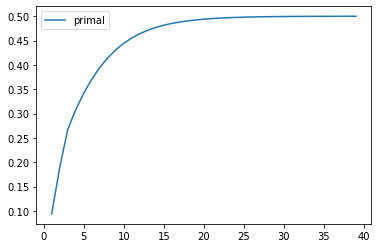

In [4]:
import matplotlib.pyplot as plt

plt.plot(np.arange(1, len(obj_val)+1), obj_val, label='primal')
# plt.plot(np.arange(1, len(lagr_val)+1), lagr_val, label='dual')
plt.legend()
plt.show()

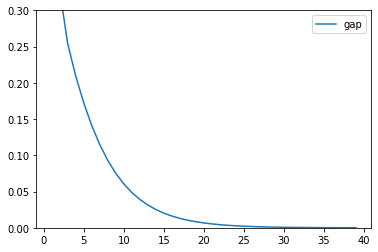

In [5]:
plt.plot(np.arange(1, len(gap)+1), gap, label='gap')
plt.ylim(0, 0.3)
plt.legend()
plt.show()

In [6]:
x.numpy()

array([0.50239414, 0.49750745], dtype=float32)

In [7]:
obj_val[-1]

0.4999135

In [8]:
gap[-1]

9.771578e-05

## Facciamo una prova passo passo

In [9]:
xs = np.array([[-2.68412563,  0.31939725],
       [-2.71414169, -0.17700123],
       [-2.88899057, -0.14494943],
       [-2.74534286, -0.31829898],
       [-2.72871654,  0.32675451],
       [-2.28085963,  0.74133045],
       [-2.82053775, -0.08946138],
       [-2.62614497,  0.16338496],
       [-2.88638273, -0.57831175],
       [-2.6727558 , -0.11377425],
       [-2.50694709,  0.6450689 ],
       [-2.61275523,  0.01472994],
       [-2.78610927, -0.235112  ],
       [-3.22380374, -0.51139459],
       [-2.64475039,  1.17876464],
       [-2.38603903,  1.33806233],
       [-2.62352788,  0.81067951],
       [-2.64829671,  0.31184914],
       [-2.19982032,  0.87283904],
       [-2.5879864 ,  0.51356031],
       [-2.31025622,  0.39134594],
       [-2.54370523,  0.43299606],
       [-3.21593942,  0.13346807],
       [-2.30273318,  0.09870885],
       [-2.35575405, -0.03728186],
       [-2.50666891, -0.14601688],
       [-2.46882007,  0.13095149],
       [-2.56231991,  0.36771886],
       [-2.63953472,  0.31203998],
       [-2.63198939, -0.19696122],
       [-2.58739848, -0.20431849],
       [-2.4099325 ,  0.41092426],
       [-2.64886233,  0.81336382],
       [-2.59873675,  1.09314576],
       [-2.63692688, -0.12132235],
       [-2.86624165,  0.06936447],
       [-2.62523805,  0.59937002],
       [-2.80068412,  0.26864374],
       [-2.98050204, -0.48795834],
       [-2.59000631,  0.22904384],
       [-2.77010243,  0.26352753],
       [-2.84936871, -0.94096057],
       [-2.99740655, -0.34192606],
       [-2.40561449,  0.18887143],
       [-2.20948924,  0.43666314],
       [-2.71445143, -0.2502082 ],
       [-2.53814826,  0.50377114],
       [-2.83946217, -0.22794557],
       [-2.54308575,  0.57941002],
       [-2.70335978,  0.10770608],
       [ 1.28482569,  0.68516047],
       [ 0.93248853,  0.31833364],
       [ 1.46430232,  0.50426282],
       [ 0.18331772, -0.82795901],
       [ 1.08810326,  0.07459068],
       [ 0.64166908, -0.41824687],
       [ 1.09506066,  0.28346827],
       [-0.74912267, -1.00489096],
       [ 1.04413183,  0.2283619 ],
       [-0.0087454 , -0.72308191],
       [-0.50784088, -1.26597119],
       [ 0.51169856, -0.10398124],
       [ 0.26497651, -0.55003646],
       [ 0.98493451, -0.12481785],
       [-0.17392537, -0.25485421],
       [ 0.92786078,  0.46717949],
       [ 0.66028376, -0.35296967],
       [ 0.23610499, -0.33361077],
       [ 0.94473373, -0.54314555],
       [ 0.04522698, -0.58383438],
       [ 1.11628318, -0.08461685],
       [ 0.35788842, -0.06892503],
       [ 1.29818388, -0.32778731],
       [ 0.92172892, -0.18273779],
       [ 0.71485333,  0.14905594],
       [ 0.90017437,  0.32850447],
       [ 1.33202444,  0.24444088],
       [ 1.55780216,  0.26749545],
       [ 0.81329065, -0.1633503 ],
       [-0.30558378, -0.36826219],
       [-0.06812649, -0.70517213],
       [-0.18962247, -0.68028676],
       [ 0.13642871, -0.31403244],
       [ 1.38002644, -0.42095429],
       [ 0.58800644, -0.48428742],
       [ 0.80685831,  0.19418231],
       [ 1.22069088,  0.40761959],
       [ 0.81509524, -0.37203706],
       [ 0.24595768, -0.2685244 ],
       [ 0.16641322, -0.68192672],
       [ 0.46480029, -0.67071154],
       [ 0.8908152 , -0.03446444],
       [ 0.23054802, -0.40438585],
       [-0.70453176, -1.01224823],
       [ 0.35698149, -0.50491009],
       [ 0.33193448, -0.21265468],
       [ 0.37621565, -0.29321893],
       [ 0.64257601,  0.01773819],
       [-0.90646986, -0.75609337],
       [ 0.29900084, -0.34889781],
       [ 2.53119273, -0.00984911],
       [ 1.41523588, -0.57491635],
       [ 2.61667602,  0.34390315],
       [ 1.97153105, -0.1797279 ],
       [ 2.35000592, -0.04026095],
       [ 3.39703874,  0.55083667],
       [ 0.52123224, -1.19275873],
       [ 2.93258707,  0.3555    ],
       [ 2.32122882, -0.2438315 ],
       [ 2.91675097,  0.78279195],
       [ 1.66177415,  0.24222841],
       [ 1.80340195, -0.21563762],
       [ 2.1655918 ,  0.21627559],
       [ 1.34616358, -0.77681835],
       [ 1.58592822, -0.53964071],
       [ 1.90445637,  0.11925069],
       [ 1.94968906,  0.04194326],
       [ 3.48705536,  1.17573933],
       [ 3.79564542,  0.25732297],
       [ 1.30079171, -0.76114964],
       [ 2.42781791,  0.37819601],
       [ 1.19900111, -0.60609153],
       [ 3.49992004,  0.4606741 ],
       [ 1.38876613, -0.20439933],
       [ 2.2754305 ,  0.33499061],
       [ 2.61409047,  0.56090136],
       [ 1.25850816, -0.17970479],
       [ 1.29113206, -0.11666865],
       [ 2.12360872, -0.20972948],
       [ 2.38800302,  0.4646398 ],
       [ 2.84167278,  0.37526917],
       [ 3.23067366,  1.37416509],
       [ 2.15943764, -0.21727758],
       [ 1.44416124, -0.14341341],
       [ 1.78129481, -0.49990168],
       [ 3.07649993,  0.68808568],
       [ 2.14424331,  0.1400642 ],
       [ 1.90509815,  0.04930053],
       [ 1.16932634, -0.16499026],
       [ 2.10761114,  0.37228787],
       [ 2.31415471,  0.18365128],
       [ 1.9222678 ,  0.40920347],
       [ 1.41523588, -0.57491635],
       [ 2.56301338,  0.2778626 ],
       [ 2.41874618,  0.3047982 ],
       [ 1.94410979,  0.1875323 ],
       [ 1.52716661, -0.37531698],
       [ 1.76434572,  0.07885885],
       [ 1.90094161,  0.11662796],
       [ 1.39018886, -0.28266094]])

In [10]:
mus = np.array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

In [11]:
x_setosa = xs[:50]
y_setosa = mus[:50]
x_virginica = xs[50:100]
y_virginica = mus[50:100]
x_versicolor = xs[100:]
y_versicolor = mus[100:]

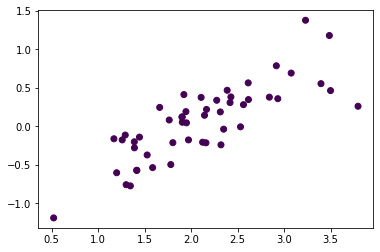

In [12]:
import matplotlib.pyplot as plt

plt.scatter(*x_versicolor.T, c=y_versicolor)
plt.show()

In [13]:
from mulearn.kernel import GaussianKernel

k = GaussianKernel()

c = 2

In [14]:
m = len(xs)

In [15]:
import tensorflow as tf

In [186]:
alphas = [tf.Variable(ch, name=f'alpha_{i}', trainable=True, dtype=tf.float32)
          for i, ch in enumerate(np.random.uniform(-0.1, 0.1, m))]
betas = [tf.Variable(ch, name=f'beta_{i}', trainable=True, dtype=tf.float32)
         for i, ch in enumerate(np.random.uniform(-0.1, 0.1, m))]

In [187]:
gram = np.array([[k.compute(x1, x2) for x2 in xs] for x1 in xs])

In [188]:
x = alphas + betas

In [189]:
K11 = np.array([[-mu_i * mu_j for mu_j in mus] for mu_i in mus]) * gram
K00 = np.array([[-(1-mu_i) * (1 - mu_j) for mu_j in mus] for mu_i in mus]) * gram
K01 = np.array([[2 * mu_i * (1-mu_j) for mu_j in mus] for mu_i in mus]) * gram
Z = np.zeros((m, m))

In [190]:
Q = -np.vstack((np.hstack((K11, K01)), np.hstack((Z, K00))))
q = -np.hstack((np.diag(gram) * mus, np.diag(gram) * (1 - mus)))

In [191]:
A = np.array([np.hstack((mus, 1-mus))])
b = np.array([1])

In [192]:
C = np.vstack((np.hstack((np.identity(m), np.zeros((m, m)))),
               np.hstack((np.zeros((m, m)), -np.identity(m)))))
d = np.hstack((np.zeros(m), - c * np.ones(m)))

In [193]:
x = np.random.random(2*m)
assert(Q.shape == (2*m, 2*m))
assert(len(q) == 2*m)
assert(type(x @ (Q @ x) + q @ x) is np.float64)

assert(A.shape == (1, 2*m))
assert(len(b) == 1)
assert(type(A@x - b) == np.ndarray)
assert(len(A@x - b) == 1)

assert(C.shape == (2*m, 2*m))
assert(len(d) == 2*m)
assert(type(C @ x - d) == np.ndarray)
assert(len(C @ x - d) == 2*m)

In [16]:
import tensorflow as tf
from tensorflow.keras.optimizers import Adam

def solve_lagrange_relaxation(Q, q, A, b, C, d,
                  max_iter=1000,
                  max_gap=10**-4,
                  alpha_0 = 10**-1,
                  window_width = 30,
                  verbose=False):
    """Solves the lagrangian relaxation for a constrained optimization
    problem and returns its result. The structure of the primal problem
    is the following
    
    min x.T Q x + q.T x
    subject to
    A x = b
    C x <= d
    
    where .T denotes the transposition operator. Optimization takes place
    in a iterated two-steps procedure: an outer process devoted to modifying
    the values of the lagrange multipliers, and an inner process working on
    the primal variables.
    
    The arguments are as follows, given n as the number of variables of
    the primal problem (i.e., the length of x)
    
    - Q: n x n matrix containing the quadratic coefficients of the cost
    function;
    - q: vector containing the n linear coefficients of the cost function
    - A: s x n matrix containing the coefficients of the = constraints
    - b: vector containing the s right members of the = constraints
    - C: t x n matrix containing the coefficients of the <= constraings
    - d: vector containing the t right members of the <= coefficients
    - max_iter: maximum number of iterations of the *outer* optimization
    procedure
    - max_gap: maximum gap between primal and dual objectives ensuring
    premature end of the *outer* optimization procedure
    - alpha_0: initial value of the learning rate in the *outer* optimization
    procedure
    - window_width: width of the moving window on the objective function for
    the *inner* optimization process
    - verbose: boolean flag triggering verbose output
    
    returns
    """

    #TODO add possibility to specify initial values

    x = tf.Variable(np.random.random(len(q)),
                    name='x',
                    trainable=True,
                    dtype=tf.float32)
    Q = tf.constant(np.array(Q), dtype='float32')
    q = tf.constant(np.array(q), dtype='float32')
    
    A = np.array(A)
    s = len(A)
    C = np.array(C)
    b = np.array(b)
    d = np.array(d)
    
    M = np.vstack([A, -A, C])
    m = np.hstack([b, -b, d])
    lambda_ = tf.constant(np.random.random(len(m)), dtype='float32')
    
    M = tf.constant(M, dtype='float32')
    m = tf.constant(m, dtype='float32')

    
    def original_objective():
        def obj():
            return tf.tensordot(tf.linalg.matvec(Q, x), x, axes=1) + \
                tf.tensordot(q, x, axes=1)
        return obj

    def lagrangian_objective(lambda_):
        def obj():
            return tf.tensordot(tf.linalg.matvec(Q, x), x, axes=1) + \
                tf.tensordot(q, x, axes=1) + \
                tf.tensordot(lambda_, m - tf.linalg.matvec(M, x), axes=1)
        return obj

    obj_val = []
    lagr_val = []
    gap_val = []
    gap = max_gap + 1

    num_bad_iterations = 0
    prev_orig = np.inf

    i = 0
    
    while i < max_iter and (gap<0 or gap > max_gap):
        lagr_obj = lagrangian_objective(lambda_)
        orig_obj = original_objective()
        prev_lagr = 10*3
        curr_lagr = 0
        vals = []
        t = 0
        window_width = 30
        window = list(np.logspace(1, window_width, window_width))
        # this is to ensure a high value for the standard deviation
        # of the elements to which the window has been initialized 
        
        while (np.std(window)/abs(np.mean(window)) > 0.001 or t < 100) \
            and t < 1000:
            optimizer.minimize(lagr_obj, var_list=x)
            prev_lagr = curr_lagr
            curr_lagr = lagr_obj().numpy()
            vals.append(curr_lagr)
            t += 1
            window = window[1:]
            window.append(curr_lagr)
        
        curr_orig = orig_obj().numpy()
        if curr_orig < prev_orig:
            num_bad_iterations += 1

        prev_orig = curr_orig

        
        obj_val.append(curr_orig)
        lagr_val.append(curr_lagr)
        
        subgradient = (m - tf.linalg.matvec(M, x)).numpy()
        gap = tf.tensordot(lambda_[:2*s], m[:2*s] - \
            tf.linalg.matvec(M[:2*s], x), axes=1).numpy()
        gap_val.append(gap)
        
        if verbose and i%10 == 0:
            print(f'i={i}, dual={lagr_obj().numpy():.3f}, '
                f'prim={orig_obj().numpy():.3f}, '
                f'gap={gap:.6f}')
        
        alpha = alpha_0 / num_bad_iterations
        lambda_ = tf.maximum(0, lambda_ + alpha * subgradient)

        i += 1

    return obj_val, lagr_val, x, lambda_, gap_val

In [28]:
sol = solve_lagrange_relaxation(Q, q, A, b, C, d, verbose=True)

NameError: name 'optimizer' is not defined

In [17]:
from mulearn import FuzzyInductor

In [18]:
import sklearn.datasets as ds
import pandas as pd
import numpy as np

iris_X, iris_y = ds.load_iris(return_X_y=True)
labels = ("Setosa", "Versicolor", "Virginica")

df = pd.DataFrame(iris_X, columns=["Sepal length", "Sepal width",
                                   "Petal length", "Petal width"])
df['Class'] = iris_y
df['Class'] = df['Class'].map(lambda c: labels[c])

n = 20
filt = list(range(n)) + list(range(50, 50+n)) + list(range(100, 100+n))
df = df.iloc[filt]

df.head()

,Sepal length,Sepal width,Petal length,Petal width,Class
0,5.1,3.5,1.4,0.2,Setosa
1,4.9,3.0,1.4,0.2,Setosa
2,4.7,3.2,1.3,0.2,Setosa
3,4.6,3.1,1.5,0.2,Setosa
4,5.0,3.6,1.4,0.2,Setosa


In [19]:
from sklearn.decomposition import PCA

pca_2d = PCA(n_components=2)
iris_X_2d = pca_2d.fit_transform(iris_X)

iris_versicolor = iris_y.copy()
iris_versicolor[iris_versicolor==2] = 0

In [20]:
from mulearn.optimization import TensorFlowSolver
from mulearn.fuzzifier import LinearFuzzifier


opt = tf.optimizers.Adam(learning_rate=1e-4)

fitf = FuzzyInductor(solver=TensorFlowSolver(optimizer=opt),
                     k=GaussianKernel(sigma=0.3),
                     fuzzifier=LinearFuzzifier())
fitf.fit(iris_X_2d, iris_versicolor)

i=0, dual=102.827, prim=242.129, gap=-55.414356
i=1, dual=357.986, prim=116.948, gap=323.034851
i=2, dual=253.775, prim=46.308, gap=291.154755
i=3, dual=100.325, prim=11.752, gap=174.763428
i=4, dual=-47.801, prim=5.365, gap=35.609734
i=5, dual=-171.988, prim=21.899, gap=-102.683548
i=6, dual=-258.151, prim=55.199, gap=-220.886414
i=7, dual=-294.699, prim=94.927, gap=-297.112335
i=8, dual=-277.160, prim=119.558, gap=-306.029297
i=9, dual=-216.890, prim=119.703, gap=-252.049225
i=10, dual=-157.622, prim=114.367, gap=-193.186325
i=11, dual=-122.937, prim=84.535, gap=-130.854065
i=12, dual=-99.620, prim=61.755, gap=-86.653015
i=13, dual=-84.435, prim=45.044, gap=-56.396461
i=14, dual=-74.877, prim=33.098, gap=-36.320381
i=15, dual=-68.864, prim=24.702, gap=-23.322838
i=16, dual=-65.050, prim=18.826, gap=-15.028122
i=17, dual=-62.515, prim=14.656, gap=-9.747955
i=18, dual=-60.734, prim=11.625, gap=-6.371319
i=19, dual=-59.380, prim=9.372, gap=-4.202564
i=20, dual=-58.285, prim=7.657, gap=-

i=177, dual=-12.523, prim=0.265, gap=0.158758
i=178, dual=-12.366, prim=0.267, gap=0.156319
i=179, dual=-12.210, prim=0.268, gap=0.153951
i=180, dual=-12.054, prim=0.269, gap=0.151655
i=181, dual=-11.896, prim=0.270, gap=0.149477
i=182, dual=-11.735, prim=0.271, gap=0.147486
i=183, dual=-11.574, prim=0.271, gap=0.145715
i=184, dual=-11.410, prim=0.271, gap=0.144255
i=185, dual=-11.248, prim=0.270, gap=0.143112
i=186, dual=-11.091, prim=0.269, gap=0.142407
i=187, dual=-10.940, prim=0.268, gap=0.142267
i=188, dual=-10.790, prim=0.265, gap=0.142776
i=189, dual=-10.641, prim=0.262, gap=0.144040
i=190, dual=-10.493, prim=0.258, gap=0.146106
i=191, dual=-10.347, prim=0.254, gap=0.149011
i=192, dual=-10.202, prim=0.248, gap=0.152730
i=193, dual=-10.059, prim=0.242, gap=0.157201
i=194, dual=-9.918, prim=0.235, gap=0.162330
i=195, dual=-9.777, prim=0.228, gap=0.167965
i=196, dual=-9.638, prim=0.220, gap=0.173953
i=197, dual=-9.501, prim=0.212, gap=0.180111
i=198, dual=-9.365, prim=0.204, gap=0.

FuzzyInductor(c=1, k=GaussianKernel(sigma=0.3), f=LinearFuzzifier(), solver=TensorFlowSolver(, optimizer=<tensorflow.python.keras.optimizer_v2.adam.Adam object at 0x7fb32b77a160>))

In [21]:
fitf.predict(iris_X_2d, alpha=0.5)

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 1, 0, 0, 0,
       1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0,
       0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1,
       1, 0, 0, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1,
       0, 1, 1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1])

In [22]:
iris_versicolor

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

In [23]:
x_space = np.linspace(-4, 4, 100)
y_space = np.linspace(-2, 2, 100)

X, Y = np.meshgrid(x_space, y_space)

In [24]:
Z = [[fitf.predict([(x, y)])[0] for x in x_space]
     for y in y_space]

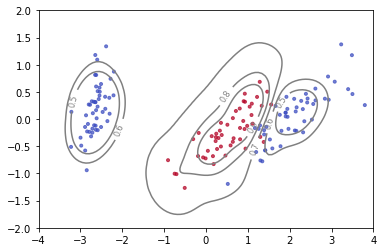

In [30]:
import matplotlib.cm as cm 

plt.scatter(*iris_X_2d.T, color=cm.coolwarm(iris_versicolor*255), s=9, alpha=0.7)
contours = plt.contour(X, Y, Z, [.5, .6, .7, .8, .9], colors='gray')
plt.clabel(contours, inline=True, fontsize=8)
plt.show()